Initialize Sentiment Analyzer

In [110]:
import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import pprint
import requests
nltk.download('vader_lexicon')
import datetime
import backtrader as bt

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nishi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Updating Vader Lexicon with External Lexicon

In [111]:
import csv
import pandas as pd

# stock market lexicon
stock_lex = pd.read_csv('lexicon_data/stock_lex.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

# Loughran and McDonald
positive = []
with open('lexicon_data/lm_positive.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        positive.append(row[0].strip())
    
negative = []
with open('lexicon_data/lm_negative.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        entry = row[0].strip().split(" ")
        if len(entry) > 1:
            negative.extend(entry)
        else:
            negative.append(entry[0])

final_lex = {}
final_lex.update({word:2.0 for word in positive})
final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [148]:
from dateutil import parser
import time
pages = 2
date_sentiments = {}
search_term = 'john keells'
for i in range(pages):
    url  = f'https://economynext.com/page/{str(i)}/?s={search_term}'
    page = requests.get(url,
                        headers = {'User-Agent': 'Mozilla/5.0'}).text
    soup = BeautifulSoup(page, 'lxml')
    posts = soup.findAll("div", {"class": "story-grid-single-story"})
    for post in posts:
        post_url = post.a['href']
        post_page = requests.get(post_url,
                        headers = {'User-Agent': 'Mozilla/5.0'}).content
        time.wait(0.1)
        story_soup = BeautifulSoup(post_page, 'lxml')
        date_str = story_soup.find('div',class_ = 'story-page-pulish-datetime').text

        #TODO: parse date_str
        story_body = story_soup.find('div',class_ = 'story-page-text-content').text
        date = parser.parse(date_str)
        if date > datetime.datetime(2020,1,1):
            print(date,post_url)



            sentiment = sia.polarity_scores(story_body)['compound']

            date_sentiments.setdefault(date, []).append(sentiment)



2021-07-29 08:42:00 https://economynext.com/sri-lankas-adani-backed-container-terminal-finalizing-design-structuring-john-keells-84389/
2021-07-28 17:47:00 https://economynext.com/sri-lanka-john-keells-holdings-back-in-profits-in-june-2021-quarter-84360/
2021-07-19 05:51:00 https://economynext.com/sri-lankas-john-keells-properties-say-tri-zen-project-on-track-84107/
2021-07-12 17:58:00 https://economynext.com/brand_voice/john-keells-holdings-the-pursuit-of-inclusive-growth/
2021-05-31 07:41:00 https://economynext.com/sri-lankas-john-keells-to-get-34-pct-of-container-terminal-adani-51-pct-report-82559/
2021-02-28 08:11:00 https://economynext.com/sri-lanka-golf-holiday-homes-launched-by-john-keells-79211/
2021-01-29 05:28:00 https://economynext.com/sri-lankas-john-keells-holdings-net-down-59-pct-in-dec-78336/
2020-11-12 12:51:00 https://economynext.com/brand_voice/john-keells-properties-leading-sri-lankas-real-estate-journey/
2020-10-11 13:23:00 https://economynext.com/sri-lankas-john-ke

In [149]:
date_sentiment = {}
for k,v in date_sentiments.items():
    #why this time delta, consider param?
    date_sentiment[k.date() + timedelta(days=1)] = round(sum(v)/float(len(v)),3) #avg sentiment for a day

earliest_date = min(date_sentiment.keys())
earliest_datetime = datetime.datetime(earliest_date.year, earliest_date.month, earliest_date.day)
print(date_sentiment)
print(earliest_date)

{datetime.date(2021, 7, 30): 0.766, datetime.date(2021, 7, 29): 0.99, datetime.date(2021, 7, 20): 0.907, datetime.date(2021, 7, 13): 1.0, datetime.date(2021, 6, 1): 0.979, datetime.date(2021, 3, 1): 0.988, datetime.date(2021, 1, 30): 0.999, datetime.date(2020, 11, 13): 1.0, datetime.date(2020, 10, 12): 0.991, datetime.date(2020, 8, 13): 0.999, datetime.date(2020, 7, 30): 0.989, datetime.date(2020, 6, 24): 0.996, datetime.date(2020, 5, 22): 0.994, datetime.date(2020, 2, 25): 0.926, datetime.date(2020, 2, 12): 0.464, datetime.date(2020, 2, 11): 0.633, datetime.date(2020, 1, 30): 0.976, datetime.date(2020, 1, 28): -0.069, datetime.date(2020, 1, 23): 0.99, datetime.date(2020, 1, 15): 1.0}
2020-01-15


<IPython.core.display.Javascript object>


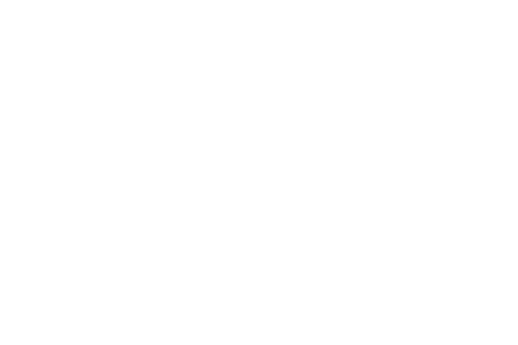

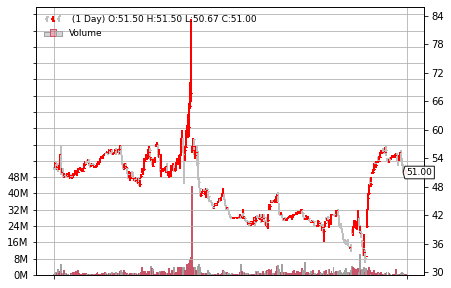

In [155]:
# for i in df.volume:
def _to_float(x):
    
    if 'M' in x:
         out = float(x[:-1])*10**6
            
    elif 'K' in x:
        out = float(x[:-1])*10**3
    else:
        out = float(x)
    
    return out


def get_datafeed(filepath, earliest_date,reverse=False):
    "Builds feed from custom csv"
    df = pd.read_csv(filepath,parse_dates = True)
    
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    df.volume = df['volume'].apply(lambda x: _to_float(x))
    
    df = df[df.datetime > earliest_datetime ]
    if reverse:
        df = df[::-1]
    data = bt.feeds.PandasData(dataname=df,
                              datetime = -1
                            )
    
    return data



def test_get_datafeed():
    """This plot should show we loaded the data succesfully"""
    # Create a cerebro entity
    cerebro = bt.Cerebro(stdstats=False)

    # Add a strategy
    cerebro.addstrategy(bt.Strategy)

    cerebro.adddata(get_datafeed('data/SAMP Historical Data.csv',earliest_date))

    # Run over everything
    cerebro.run()

    # Plot the result
    cerebro.plot(style='bar')

test_get_datafeed()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    466 non-null    datetime64[ns]
 1   close       466 non-null    float64       
 2   open        466 non-null    float64       
 3   high        466 non-null    float64       
 4   low         466 non-null    float64       
 5   volume      466 non-null    float64       
 6   Unnamed: 6  0 non-null      float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 25.6 KB


<IPython.core.display.Javascript object>


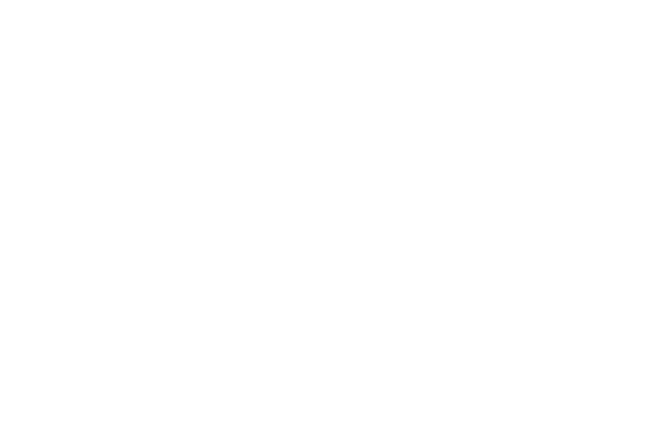

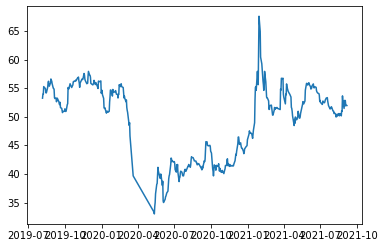

In [128]:
df = pd.read_csv('data/SAMP Historical Data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.volume = df['volume'].apply(lambda x: to_float(x))
# df.volume = pd.to_numeric(df.volume)
df.info()
df.isna().sum()
import matplotlib.pyplot as plt
plt.plot(df.datetime,df.close)

Scraping FB posts from Business Times

In [129]:
# from urllib.request import urlopen
# from bs4 import BeautifulSoup
# from datetime import datetime, timedelta
# import time
# import pprint
# import requests
# date_sentiments = {}

# for i in range(1,3):
#     page = requests.get('https://www.businesstimes.com.sg/search/facebook?page='+str(i)).text
#     soup = BeautifulSoup(page, 'lxml')
#     posts = soup.findAll("div", {"class": "media-body"})

#     for post in posts:
#         time.sleep(1)
#         url = post.a['href']
#         date = post.time.text
#         print(date)
#         print(date, url)
#         try:
#             link_page = urlopen(url).read()
#         except:
#             url = url[:-2]
#             link_page = urlopen(url).read()
#         link_soup = BeautifulSoup(link_page)
#         sentences = link_soup.findAll("p")
#         passage = ""
#         for sentence in sentences:
#             passage += sentence.text
        
#         sentiment = sia.polarity_scores(passage)['compound']
#         date_sentiments.setdefault(date, []).append(sentiment)



# for k,v in date_sentiments.items():
#     date_sentiment[datetime.strptime(k, '%d %b %Y').date() + timedelta(days=1)] = round(sum(v)/float(len(v)),3)

# earliest_date = min(date_sentiment.keys())

# print(date_sentiment)

Algorithm

Starting Portfolio Value: 100000.00
2020-01-27, Close, 54.00
None None
2020-01-28, Close, 53.67
-0.069 None
2020-01-29, Close, 54.83
-0.069 -0.069
2020-01-30, Close, 54.67
0.976 -0.069
2020-01-30, BUY CREATE, 54.67
2020-01-31, BUY EXECUTED, Price: 54.67, Cost: 546.70, Comm 0.55
2020-01-31, Close, 54.33
0.976 0.976
2020-02-03, Close, 54.40
0.976 0.976
2020-02-03, SELL CREATE, 54.40
2020-02-05, SELL EXECUTED, Price: 54.63, Cost: 546.70, Comm 0.55
2020-02-05, OPERATION PROFIT, GROSS -0.40, NET -1.49
2020-02-05, Close, 54.63
0.976 0.976
2020-02-06, Close, 54.33
0.976 0.976
2020-02-07, Close, 54.00
0.976 0.976
2020-02-10, Close, 53.97
0.976 0.976
2020-02-11, Close, 53.33
0.633 0.976
2020-02-12, Close, 53.97
0.464 0.633
2020-02-13, Close, 53.97
0.464 0.464
2020-02-14, Close, 55.67
0.464 0.464
2020-02-17, Close, 55.33
0.464 0.464
2020-02-18, Close, 55.67
0.464 0.464
2020-02-19, Close, 55.83
0.464 0.464
2020-02-20, Close, 55.33
0.464 0.464
2020-02-24, Close, 55.17
0.464 0.464
2020-02-25, Close

2021-04-07, Close, 53.90
0.988 0.988
2021-04-08, Close, 55.80
0.988 0.988
2021-04-09, Close, 55.30
0.988 0.988
2021-04-12, Close, 54.50
0.988 0.988
2021-04-15, Close, 54.10
0.988 0.988
2021-04-16, Close, 54.00
0.988 0.988
2021-04-19, Close, 53.50
0.988 0.988
2021-04-20, Close, 51.70
0.988 0.988
2021-04-21, Close, 51.50
0.988 0.988
2021-04-22, Close, 51.00
0.988 0.988
2021-04-23, Close, 50.20
0.988 0.988
2021-04-27, Close, 48.50
0.988 0.988
2021-04-28, Close, 49.60
0.988 0.988
2021-04-29, Close, 48.90
0.988 0.988
2021-04-30, Close, 50.00
0.988 0.988
2021-05-03, Close, 49.50
0.988 0.988
2021-05-04, Close, 49.60
0.988 0.988
2021-05-05, Close, 49.80
0.988 0.988
2021-05-06, Close, 50.10
0.988 0.988
2021-05-07, Close, 51.00
0.988 0.988
2021-05-10, Close, 49.80
0.988 0.988
2021-05-11, Close, 49.80
0.988 0.988
2021-05-12, Close, 50.00
0.988 0.988
2021-05-13, Close, 50.60
0.988 0.988
2021-05-17, Close, 51.90
0.988 0.988
2021-05-18, Close, 52.20
0.988 0.988
2021-05-19, Close, 52.70
0.988 0.988
2

<IPython.core.display.Javascript object>


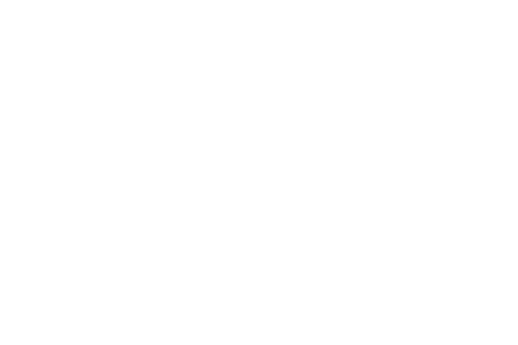

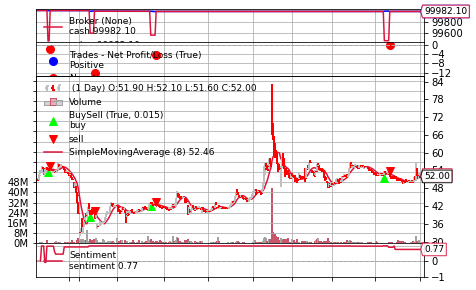

In [158]:
from __future__ import (absolute_import, division, print_function,
                            unicode_literals)

# %matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')
import yfinance as yf
import backtrader as bt
import backtrader.indicators as btind
import datetime
import os.path
# import sys

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.15,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])

        
    def next(self):
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        try:
            self.lines.sentiment[0] = self.sentiment
        except:
            self.lines.sentiment[0] = 0
            


class SentimentStrat(bt.Strategy):
    params = (
        ('period', 8),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):
        # log closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
#         date = bt.num2date(self.date[0]).date()
        date  = self.datetime.date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return
        print(self.sentiment,prev_sentiment)
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
#         if prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.01:
#             if self.sentiment - prev_sentiment <= +0.01:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
#             sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] or self.sentiment - prev_sentiment <= -0.01:
#             if self.sentiment - prev_sentiment <= -0.01:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)
        


if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    # Strategy
    cerebro.addstrategy(SentimentStrat)

    # Data Feed
    data = get_datafeed('data/SAMP Historical Data.csv',earliest_date,reverse=True)

    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)
    cerebro.broker.setcommission(commission=0.001)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    cerebro.plot()
